# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model
from collections import Counter

# Preparing Data

In [2]:
train_images = glob.glob('/kaggle/input/fer2013/train/*/*.jpg')
train_images[0]

'/kaggle/input/fer2013/train/surprise/Training_66056468.jpg'

In [3]:
len(train_images)

28709

In [4]:
emotion_mapping = {
    'angry': 0, 'disgust': 1, 'fear': 2, 
    'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6
}

In [5]:
train_data = pd.DataFrame({
    'path': train_images,
    'emotion': [next((v for k, v in emotion_mapping.items() if k in path), None) for path in train_images]
})

In [6]:
train_data

,path,emotion
0,/kaggle/input/fer2013/train/surprise/Training_...,6
1,/kaggle/input/fer2013/train/surprise/Training_...,6
2,/kaggle/input/fer2013/train/surprise/Training_...,6
3,/kaggle/input/fer2013/train/surprise/Training_...,6
4,/kaggle/input/fer2013/train/surprise/Training_...,6
...,...,...
28704,/kaggle/input/fer2013/train/happy/Training_188...,3
28705,/kaggle/input/fer2013/train/happy/Training_165...,3
28706,/kaggle/input/fer2013/train/happy/Training_108...,3
28707,/kaggle/input/fer2013/train/happy/Training_304...,3


In [7]:
test_images = glob.glob('/kaggle/input/fer2013/test/*/*.jpg')
test_images[0]

'/kaggle/input/fer2013/test/surprise/PublicTest_78686873.jpg'

In [8]:
len(test_images)

7178

In [9]:
test_data = pd.DataFrame({
    'path': test_images,
    'emotion': [next((v for k, v in emotion_mapping.items() if k in path), None) for path in test_images]
})

In [10]:
test_data

,path,emotion
0,/kaggle/input/fer2013/test/surprise/PublicTest...,6
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,6
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,6
3,/kaggle/input/fer2013/test/surprise/PublicTest...,6
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,6
...,...,...
7173,/kaggle/input/fer2013/test/happy/PublicTest_13...,3
7174,/kaggle/input/fer2013/test/happy/PublicTest_70...,3
7175,/kaggle/input/fer2013/test/happy/PublicTest_24...,3
7176,/kaggle/input/fer2013/test/happy/PrivateTest_7...,3


In [11]:
df = pd.concat([train_data, test_data], ignore_index=False)

In [12]:
df

,path,emotion
0,/kaggle/input/fer2013/train/surprise/Training_...,6
1,/kaggle/input/fer2013/train/surprise/Training_...,6
2,/kaggle/input/fer2013/train/surprise/Training_...,6
3,/kaggle/input/fer2013/train/surprise/Training_...,6
4,/kaggle/input/fer2013/train/surprise/Training_...,6
...,...,...
7173,/kaggle/input/fer2013/test/happy/PublicTest_13...,3
7174,/kaggle/input/fer2013/test/happy/PublicTest_70...,3
7175,/kaggle/input/fer2013/test/happy/PublicTest_24...,3
7176,/kaggle/input/fer2013/test/happy/PrivateTest_7...,3


In [13]:
df['emotion'].value_counts()

emotion
3    8989
4    6198
5    6077
2    5121
0    4953
6    4002
1     547
Name: count, dtype: int64

In [14]:
X = []
y = []
for feature, label in df.values:
    image = cv2.imread(feature, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48), interpolation = cv2.INTER_LINEAR)
    image = image / 255.0
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

# Data Augmentation

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    shear_range=0.1,          
    zoom_range=0.1,  
    horizontal_flip=True,     
    fill_mode='nearest'       
)

In [16]:
class_counts = Counter(y)
max_count = max(class_counts.values())  

augmented_X = []
augmented_y = []

for label in class_counts:
    images = X[y == label]  
    current_count = class_counts[label]  
    needed = max_count - current_count  

    if needed > 0:  
        generated_images = []
        generated_labels = []

        for img in images:
            img = img.reshape((1, 48, 48, 1))  
            for _ in range(needed // len(images) + 1):  
                augmented = next(datagen.flow(img, batch_size=1))
                generated_images.append(augmented[0])
                generated_labels.append(label)
                if len(generated_images) >= needed:  
                    break

        augmented_X.extend(generated_images)
        augmented_y.extend(generated_labels)

augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [17]:
X = X.reshape(-1, 48, 48, 1)
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [18]:
print(X.shape)  
print(y.shape)

(73192, 48, 48, 1)
(73192,)


# Split Data Into Train & Test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 58553
Length of Testing Data: 14639


In [21]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

# Model Building & Training

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))  

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))  
model.add(Dense(7, activation='softmax'))  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,5

 Total params: 5,114,503 (19.51 MB)

 Trainable params: 5,112,519 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
history = model.fit (
    X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=30, callbacks=[early_stopping, lr_reduction],
    shuffle=True
)

Epoch 1/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.2972 - loss: 2.1118 - val_accuracy: 0.3780 - val_loss: 1.7035 - learning_rate: 0.0010
Epoch 2/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.4926 - loss: 1.3388 - val_accuracy: 0.3834 - val_loss: 2.8688 - learning_rate: 0.0010
Epoch 3/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5369 - loss: 1.2255 - val_accuracy: 0.5687 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 4/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5702 - loss: 1.1334 - val_accuracy: 0.5901 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 5/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5969 - loss: 1.0669 - val_accuracy: 0.5862 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 6/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6222 - loss: 1.0000 - val_accuracy: 0.5356 - val_loss: 1.2789 - learning_rate: 0.0010
Epoch 7/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6379 - l

# Model Evaluation

In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6732 - loss: 1.1710
Test Accuracy: 0.6767538785934448
Loss: 1.170523762702942


In [26]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1989
           1       0.85      0.93      0.89      1815
           2       0.57      0.41      0.48      2037
           3       0.81      0.84      0.83      1799
           4       0.58      0.70      0.64      2454
           5       0.55      0.58      0.57      2498
           6       0.79      0.82      0.80      2047

    accuracy                           0.68     14639
   macro avg       0.68      0.69      0.68     14639
weighted avg       0.67      0.68      0.67     14639



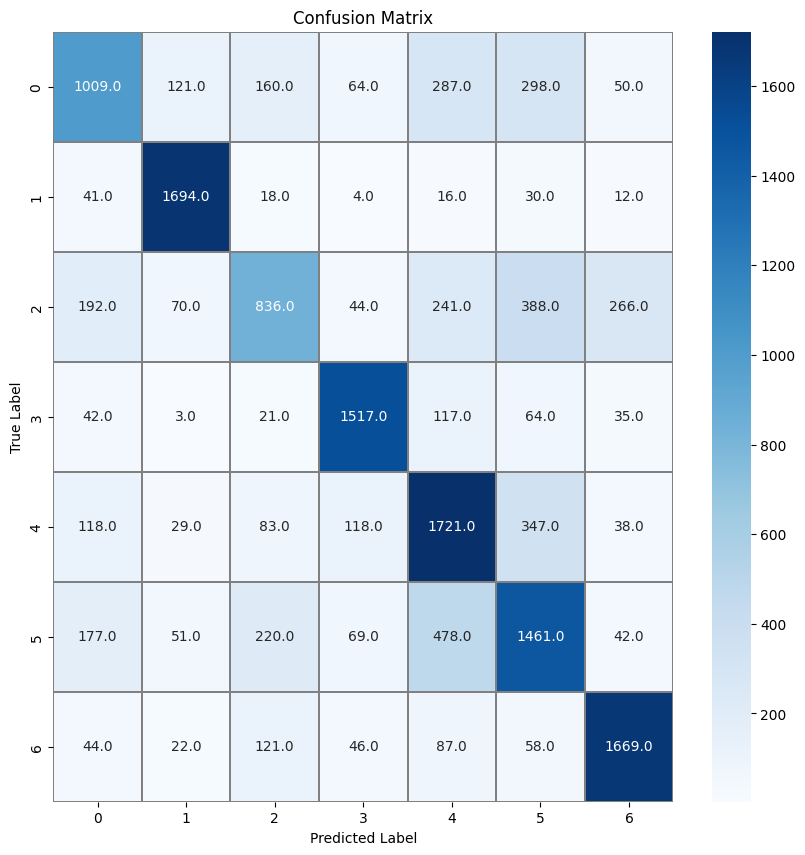

In [27]:
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

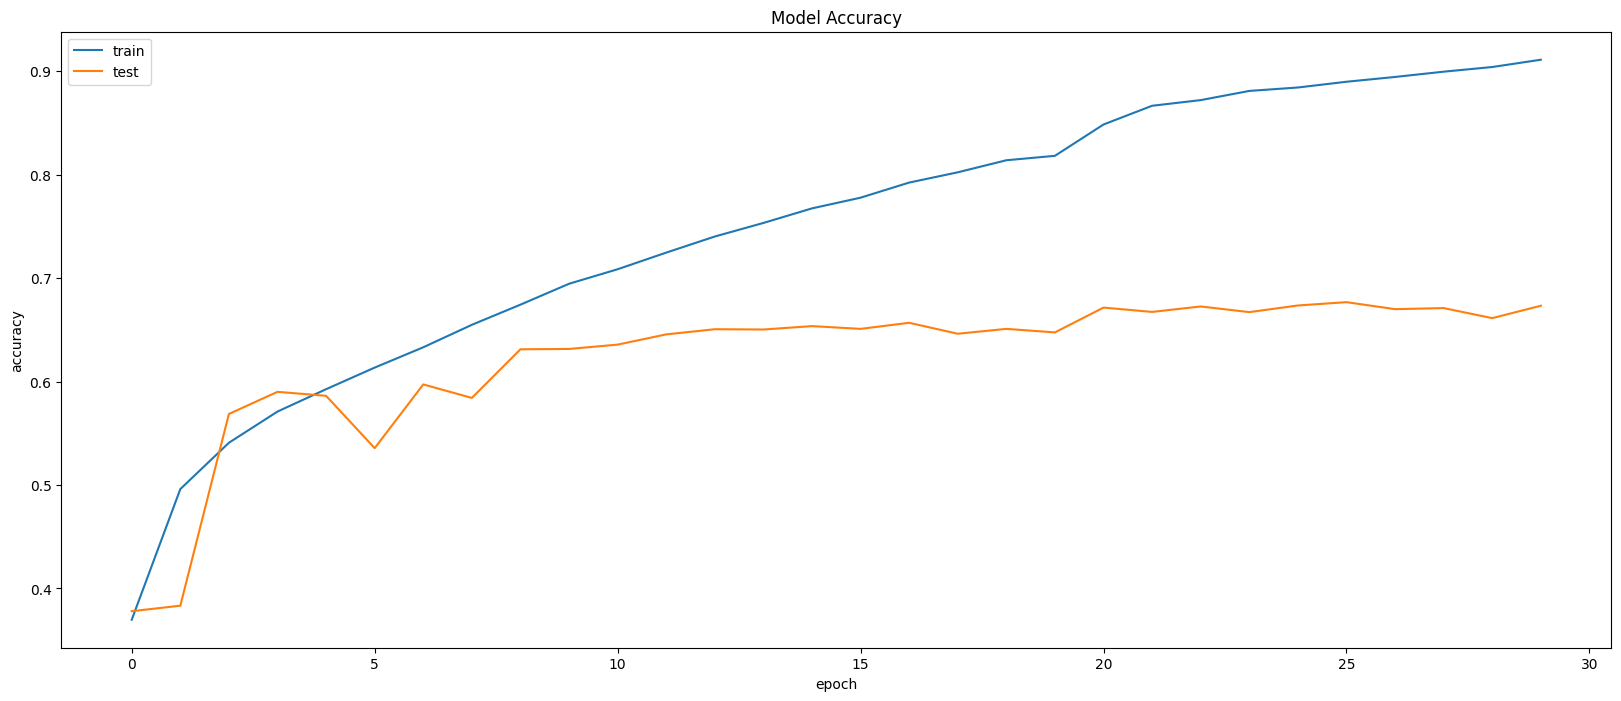

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

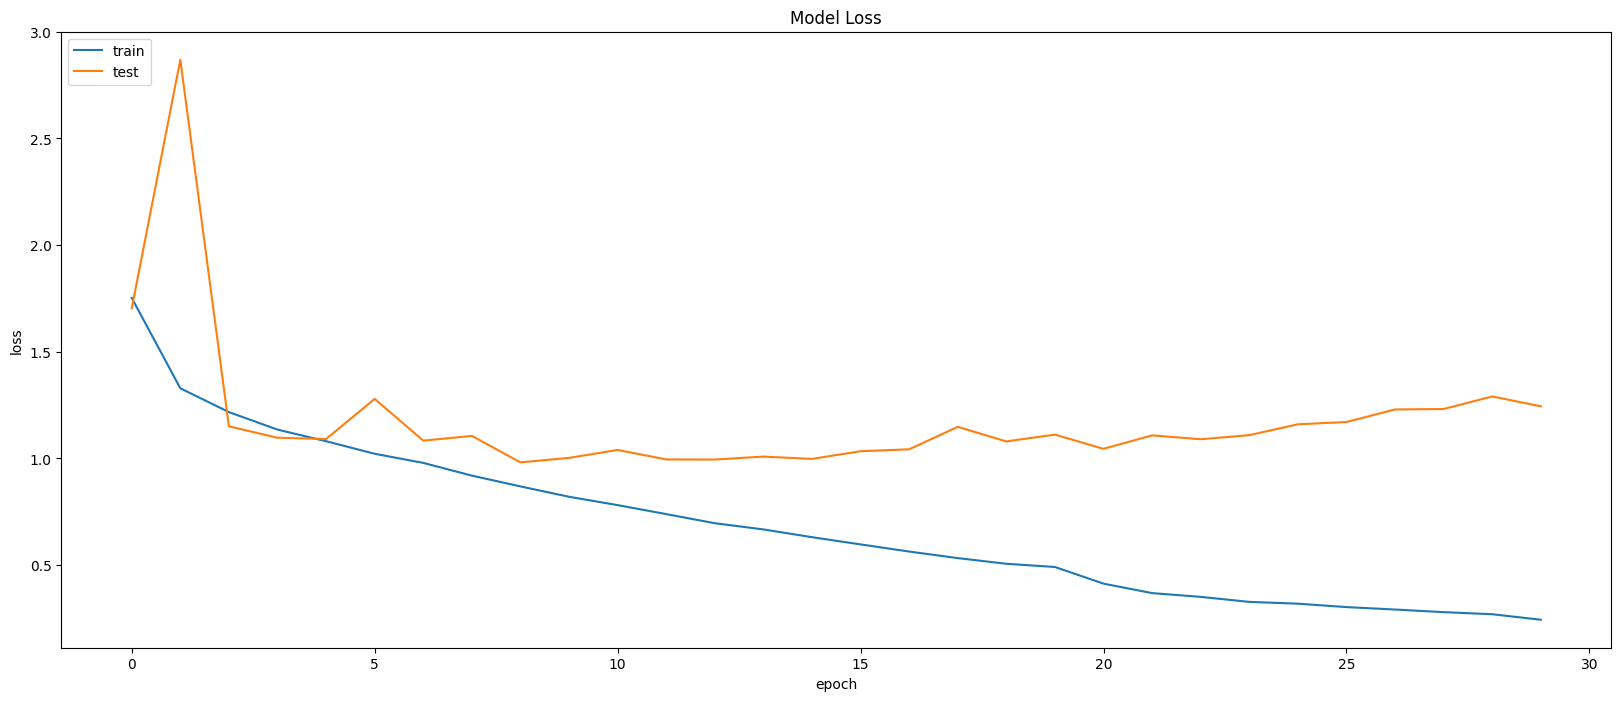

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save Model

In [30]:
model.save('/kaggle/working/model.h5')